In [43]:
import io

import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import os
from PIL import Image

In [91]:
class LabeledImage:
  def __init__(self):
    self.image_path = ""
    self.labels = []

class PKDataset:
  def __init__(self, root):
    self.images = []
    self.labels = []
    self.image_metadata = []
    for filename in os.scandir(root):
      #Ignore top level files
      if filename.is_dir():
        self.load_dir(filename)

  def load_dir(self, directory: os.DirEntry):
    for entry in os.scandir(directory):
      if entry.is_file():
        if entry.name.endswith('.jpg'):
          #Labels are the directory names, except for the file name
          labels = entry.path.split(os.sep)
          #Filename
          labels.pop(-1)
          #Misc directories that aren't labels
          labels.remove('PKLot')
          labels.remove("PkLot")
          labels.remove(".")
          labels = set(labels)
          self.images.append(entry)
          self.labels.append(labels)
          # just make sure that the labels and entries match up
          assert len(self.images) == len(self.labels)
      elif entry.is_dir():
        self.load_dir(entry)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    file = open(self.images[index].path, mode='r')
    image = file.read()
    return Image.open(io.BytesIO(image)), self.labels[index]

In [90]:
transform = torch.nn.Sequential(T.Resize((720, 1280)))
pk_data = torchvision.datasets.ImageFolder('./PKLot/PkLot', transform=transform)
alt = PKDataset('./PKLot/PkLot')
pk_images = torch.utils.data.DataLoader(pk_data, batch_size=1, pin_memory=True)
print(pk_data[12001])
print(pk_data.classes)
print(alt[0])

(<PIL.Image.Image image mode=RGB size=1280x720 at 0x7FE58052B880>, 2)
['PUCPR', 'UFPR04', 'UFPR05']


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte

Dataset ImageFolder
    Number of datapoints: 12417
    Root location: ./PKLot/PkLot
    StandardTransform
Transform: Sequential(
             (0): CenterCrop(size=(500, 500))
           )


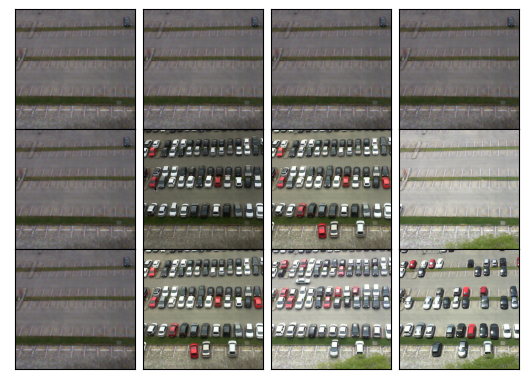

In [24]:
print(pk_data)
nrow = 3
ncol = 4
gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.0, hspace=0.0,
                       top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
                       left=0.5/(ncol+1), right=1-0.5/(ncol+1))
for i in range(0, nrow):
  for j in range(0, ncol):
    ax = plt.subplot(gs[i, j])
    plt.xticks([])
    plt.yticks([])
    ax.imshow(pk_data[i*j*20][0])
plt.show()

In [ ]:
net = torch.nn.Sequential()
net.